In [1]:
import pandas as pd
import numpy as np
import copy
import os
import datetime
from helpers import wgs_to_rd
from timedependency import *
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from bgt_reader import get_properties, WMTS_calculator, bgt_classifier

In [2]:
def predict(year, name, tree_number, origin, type, data_df):
    '''for 1 tree'''

    # if year of planting is not known it is not possible to determine age
    if origin == 0:
        return 0, 0
    circulation = year - origin

    # age is the same as circulation
    age = year - origin

    # predict dbh
    dbh = predict_value(age, name, 'age', 'dbh', data_df)

    # predict height
    height = predict_value(dbh, name, 'dbh', 'tree ht', data_df)
    if not height:
        return 0, 0

    # predict crown
    crown_diameter = predict_value(dbh, name, 'dbh', 'crown dia', data_df)

    return height, crown_diameter

In [3]:
data_year = 2020 # from what year is the data 

# load in df from paper
data_df = pd.read_csv('data/RDS-2016-0005/Data/TS6_Growth_coefficients.csv')
climate = 'PacfNW'
data_df = data_df.drop(data_df[data_df.Region != climate].index)
species = data_df['Scientific Name'].unique()


In [4]:
def validate(df, cobra_df, data_df, species, data_year, colors, boundaries): 
    height_list_model = [[],[]]
    crown_list_model = [[],[]]
    height_list_data = [[],[]]
    crown_list_data = [[],[]]
    height_list_cobra = [[],[]]
    height_list_model_cobra = [[],[]]
    results_df = copy.deepcopy(df)
    
    results_df['Gemeente height'] = np.nan
    
    results_df['Predicted height'] = np.nan
    results_df['Predicted crown'] = np.nan
    
    results_df['Cobra height'] = np.nan
    results_df['Cobra crown'] = np.nan
    
    results_df['Species'] = np.nan
    results_df['BGT_class'] = None
    
    results_df['Colors'] = 'black'

    for i, tree in df.iterrows():
        type = tree['Boomtype']
        if type == 'Vormboom' or type == 'Knotboom':
            continue

        # retrieve tree id
        tree_number = tree['Boomnummer']

        # read out name and type
        name = tree['Soortnaam_WTS']

        if name in species:
            results_df.at[i, 'Species'] = 1
        else: 
            results_df.at[i, 'Species'] = 0
        
        # read out tree position
        lng = tree['LNG']
        lat = tree['LAT']
        rd_x, rd_y = wgs_to_rd(lat, lng)

#         # determine type of ground from bgt
#         col, row, i_index, j_index = WMTS_calculator(rd_x, rd_y)
#         try:
#             properties = get_properties(col, row, i_index, j_index)
#             bgt_class = bgt_classifier(properties)
#         except:
#             print('BGT retrieval function was not executed')
#             bgt_class = None
#         results_df.at[i, 'BGT_class'] = bgt_class

        # read out origin
        origin = tree['Plantjaar']
        
#         if origin < boundaries[0]:
#             results_df.at[i, 'Colors'] = colors[0]
#         if origin >= boundaries[0] and origin < boundaries[1]:
#             results_df.at[i, 'Colors'] = colors[1]
#         if origin >= boundaries[1] and origin < boundaries[2]:
#             results_df.at[i, 'Colors'] = colors[2]
#         if origin >= boundaries[2] and origin < boundaries[3]:
#             results_df.at[i, 'Colors'] = colors[3]            
#         if origin >= boundaries[3]:
#             results_df.at[i, 'Colors'] = colors[4]  
            
        # predict height and crown with model
        height_model, crown_model = predict(data_year, name, tree_number, origin, type, data_df)
        results_df.at[i, 'Predicted height'] = height_model
        results_df.at[i, 'Predicted crown'] = crown_model

        # read out height string from gemeente data and convert to average of the range
        height_string = tree['Boomhoogte']
        if height_string != 'Onbekend' and height_model != 0:
            height_range = []
            for word in height_string.split():
                if word.isdigit():
                    height_range.append(int(word))
            height_data = np.mean(height_range)
            results_df.at[i, 'Gemeente height'] = height_data

        # retrieve cobra crown and height
        index = cobra_df.index[cobra_df.uid_gemeente == tree_number]
        if len(index) != 0 and crown_model > 0:
            crown_data = cobra_df.at[index[0], 'kroondiameter']
            height_cobra = cobra_df.at[index[0], 'boomhoogte']
            if height_cobra > 3:
                results_df.at[i, 'Cobra height'] = height_cobra
                results_df.at[i, 'Cobra crown'] = crown_data
    
    return results_df

In [5]:
def plotfunc(results_df, area, x_max_1, x_max_2):
    # plot gemeente height against predicted height
    plt.scatter(results_df['Predicted height'][results_df['Species'] == 0], results_df['Gemeente height'][results_df['Species'] == 0], c='C0', alpha=0.4, label='genus')
    plt.scatter(results_df['Predicted height'][results_df['Species'] == 1], results_df['Gemeente height'][results_df['Species'] == 1], c='C1', alpha=0.4, label='species')
    plt.xlabel('predicted height (m)', fontsize=14)
    plt.ylabel('data height (m)', fontsize=14)
    x=np.arange(0,x_max_1+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_1)
    plt.fill_between(x, x+1.5, x-1.5, color='black', alpha=0.1)
    plt.legend()
    plt.axhline(8, color='red')
    plt.axhline(15, color='red')
    plt.axvline(8, color='red')
    plt.axvline(15, color='red')
    plt.savefig('plots/gemeente_height_species_lines{}'.format(area), dpi=300)
    plt.show()

    # plot cobra height against predicted 
    plt.scatter(results_df['Predicted height'][results_df['Species'] == 0], results_df['Cobra height'][results_df['Species'] == 0], c='C0', alpha=0.4, label='genus')
    plt.scatter(results_df['Predicted height'][results_df['Species'] == 1], results_df['Cobra height'][results_df['Species'] == 1], c='C1', alpha=0.4, label='species')
    plt.xlabel('predicted height (m)', fontsize=14)
    plt.ylabel('cobra height (m)', fontsize=14)
    x=np.arange(0,x_max_1+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_1)
    plt.legend()
    plt.axhline(8, color='red')
    plt.axhline(15, color='red')
    plt.axvline(8, color='red')
    plt.axvline(15, color='red')
    plt.savefig('plots/cobra_height_species_lines{}'.format(area), dpi=300)
    plt.show()
    
    # plot cobra crown against predicted crown
    plt.scatter(results_df['Predicted crown'][results_df['Species'] == 0], results_df['Cobra crown'][results_df['Species'] == 0], c='C0', alpha=0.4, label='genus')
    plt.scatter(results_df['Predicted crown'][results_df['Species'] == 1], results_df['Cobra crown'][results_df['Species'] == 1], c='C1', alpha=0.4, label='species')
    plt.xlabel('predicted crown (m)', fontsize=14)
    plt.ylabel('data crown (m)', fontsize=14)
    x=np.arange(0,x_max_2+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_2)
    plt.legend()
    plt.savefig('plots/crown_species_lines{}'.format(area), dpi=300)
    plt.show()


In [6]:
def plotfunc_years(results_df, area, x_max_1, x_max_2, colors, boundaries):
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], label='< {}'.format(boundaries[0])),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], label='{} - {}'.format(boundaries[0], boundaries[1])),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[2], label='{} - {}'.format(boundaries[1], boundaries[2])),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[3], label='{} - {}'.format(boundaries[2], boundaries[3])),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4], label='> {}'.format(boundaries[3]))
                    ]
    
    # plot gemeente height against predicted height
    plt.scatter(results_df['Predicted height'], results_df['Gemeente height'], c=results_df['Colors'], alpha=0.4)
    plt.xlabel('predicted height (m)', fontsize=14)
    plt.ylabel('data height (m)', fontsize=14)
    x=np.arange(0,x_max_1+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_1)
    plt.fill_between(x, x+1.5, x-1.5, color='black', alpha=0.1)
    plt.legend(handles=legend_elements)
    plt.savefig('plots/gemeente_height_{}'.format(area), dpi=300)
    plt.show()

    # plot cobra height against predicted 
    plt.scatter(results_df['Predicted height'], results_df['Cobra height'], c=results_df['Colors'], alpha=0.4)
    plt.xlabel('predicted height (m)', fontsize=14)
    plt.ylabel('cobra height (m)', fontsize=14)
    x=np.arange(0,x_max_1+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_1)
    plt.legend(handles=legend_elements)
    plt.savefig('plots/cobra_height_{}'.format(area), dpi=300)
    plt.show()
    
    # plot cobra crown against predicted crown
    plt.scatter(results_df['Predicted crown'], results_df['Cobra crown'], c=results_df['Colors'], alpha=0.4)
    plt.xlabel('predicted crown (m)', fontsize=14)
    plt.ylabel('data crown (m)', fontsize=14)
    x=np.arange(0,x_max_2+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_2)
    plt.legend(handles=legend_elements)
    plt.savefig('plots/crown_{}'.format(area), dpi=300)
    plt.show()

In [7]:
colors = ['maroon', 'red', 'darkorange', 'yellow', 'greenyellow']
boundaries = [1950, 1970, 1990, 2010]

In [8]:
# load in data for Wallengebied
cobra_df = pd.read_csv('data/cobra_data.csv')
df = pd.read_csv('data/wallengebied_trees.csv')
results_df_wallengebied = validate(df, cobra_df, data_df, species, data_year, colors, boundaries)
display(results_df_wallengebied.head())

,Unnamed: 0,OBJECTNUMMER,Soortnaam_NL,Boomnummer,Soortnaam_WTS,Boomtype,Boomhoogte,Plantjaar,Eigenaar,Beheerder,...,LAT,Unnamed: 17,Gemeente height,Predicted height,Predicted crown,Cobra height,Cobra crown,Species,BGT_class,Colors
0,186057,186058,Onbekend,0,Onbekend,NaN,Onbekend,0,Gemeente Amsterdam,Stadsdeel Centrum,...,52.369158,NaN,NaN,0.0,0.0,NaN,NaN,0.0,None,black
1,187138,187139,Onbekend,0,Onbekend,NaN,Onbekend,0,Gemeente Amsterdam,Stadsdeel Centrum,...,52.367219,NaN,NaN,0.0,0.0,NaN,NaN,0.0,None,black
2,187168,187169,Onbekend,0,Onbekend,NaN,Onbekend,0,Gemeente Amsterdam,Stadsdeel Centrum,...,52.367094,NaN,NaN,0.0,0.0,NaN,NaN,0.0,None,black
3,187169,187170,Onbekend,0,Onbekend,NaN,Onbekend,0,Gemeente Amsterdam,Stadsdeel Centrum,...,52.367050,NaN,NaN,0.0,0.0,NaN,NaN,0.0,None,black
4,187567,187568,Onbekend,0,Onbekend,NaN,Onbekend,0,Gemeente Amsterdam,Stadsdeel Centrum,...,52.368733,NaN,NaN,0.0,0.0,NaN,NaN,0.0,None,black


In [9]:
# load in data for IJburg
cobra_df = pd.read_csv('data/cobra_data.csv')
df = pd.read_csv('data/ijburg_trees.csv')
results_df_ijburg = validate(df, cobra_df, data_df, species, data_year, colors, boundaries)
display(results_df_ijburg.head())


,Unnamed: 0,OBJECTNUMMER,Soortnaam_NL,Boomnummer,Soortnaam_WTS,Boomtype,Boomhoogte,Plantjaar,Eigenaar,Beheerder,...,LAT,Unnamed: 17,Gemeente height,Predicted height,Predicted crown,Cobra height,Cobra crown,Species,BGT_class,Colors
0,1056,1057,Valse acacia,1532047,Robinia pseudoacacia,Boom niet vrij uitgroeiend,tot 6 m.,2016,Gemeente Amsterdam,Stadsdeel Oost,...,52.355423,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,None,black
1,1061,1062,Oosterse plataan (cultuurvariëteit),1531643,Platanus orientalis cuneata,Boom niet vrij uitgroeiend,tot 6 m.,2016,Gemeente Amsterdam,Stadsdeel Oost,...,52.353748,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,None,black
2,1064,1065,Valse acacia,1531640,Robinia pseudoacacia,Boom niet vrij uitgroeiend,tot 6 m.,2016,Gemeente Amsterdam,Stadsdeel Oost,...,52.359626,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,None,black
3,1068,1069,Iep (cultuurvariëteit),1531636,Ulmus `Homestead`,Boom niet vrij uitgroeiend,tot 6 m.,2016,Gemeente Amsterdam,Stadsdeel Oost,...,52.357162,NaN,6.0,5.622639,3.014212,6.909417,4.600827,0.0,None,black
4,1081,1082,Zilverlinde,1266121,Tilia tomentosa,Boom niet vrij uitgroeiend,tot 6 m.,2016,Gemeente Amsterdam,Stadsdeel Oost,...,52.357936,NaN,6.0,4.178971,1.901450,NaN,NaN,0.0,None,black


In [10]:
# load in data for Sarphati
cobra_df = pd.read_csv('data/cobra_data.csv')
df = pd.read_csv('data/sarphati_trees.csv')
results_df_sarphati = validate(df, cobra_df, data_df, species, data_year, colors, boundaries)
display(results_df_sarphati.head())

,Unnamed: 0,OBJECTNUMMER,Soortnaam_NL,Boomnummer,Soortnaam_WTS,Boomtype,Boomhoogte,Plantjaar,Eigenaar,Beheerder,...,LAT,Unnamed: 17,Gemeente height,Predicted height,Predicted crown,Cobra height,Cobra crown,Species,BGT_class,Colors
0,11665,11666,Witte paardenkastanje,592133,Aesculus hippocastanum,Boom niet vrij uitgroeiend,Onbekend,1996,Gemeente Amsterdam,Stadsdeel Zuid,...,52.355025,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,None,black
1,11667,11668,Rode paardenkastanje (cultuurvariëteit),592131,Aesculus carnea `Plantierensis`,Boom niet vrij uitgroeiend,Onbekend,1996,Gemeente Amsterdam,Stadsdeel Zuid,...,52.353562,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,None,black
2,21793,21794,Veldesdoorn,582473,Acer campestre,Boom vrij uitgroeiend,Onbekend,1990,Gemeente Amsterdam,Stadsdeel Zuid,...,52.354215,NaN,NaN,16.248494,12.047352,NaN,NaN,0.0,None,black
3,22942,22943,Witte paardenkastanje (cultuurvariëteit),583439,Aesculus hippocastanum `Pyramidalis`,Boom niet vrij uitgroeiend,Onbekend,1994,Gemeente Amsterdam,Stadsdeel Zuid,...,52.355121,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,None,black
4,23041,23042,Tamme kastanje,583421,Castanea sativa,Boom niet vrij uitgroeiend,6 tot 9 m.,2003,Gemeente Amsterdam,Stadsdeel Zuid,...,52.354667,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,None,black


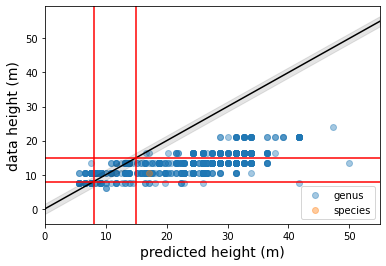

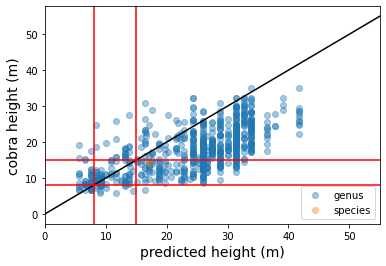

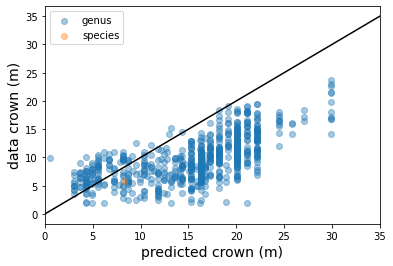

In [11]:
area = 'Wallengebied'
x_max_1, x_max_2 = 55, 35
plotfunc(results_df_wallengebied, area, x_max_1, x_max_2)

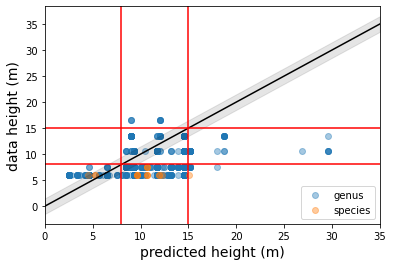

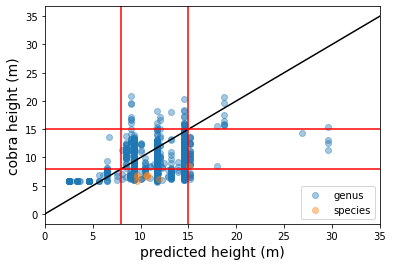

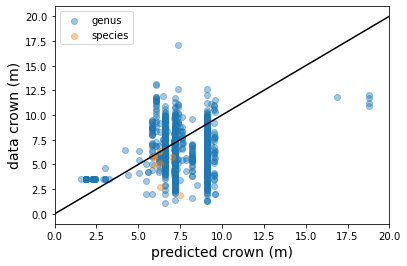

In [12]:
area = 'IJburg'
x_max_1, x_max_2 = 35, 20
plotfunc(results_df_ijburg, area, x_max_1, x_max_2)

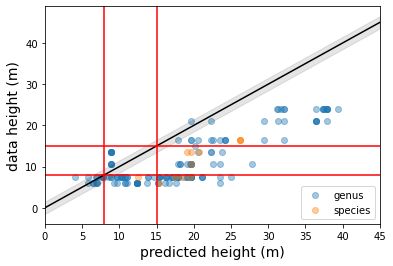

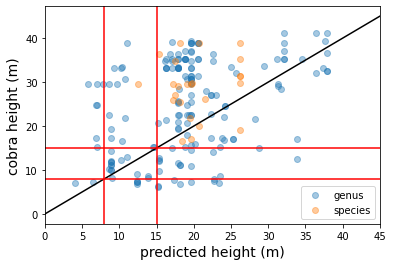

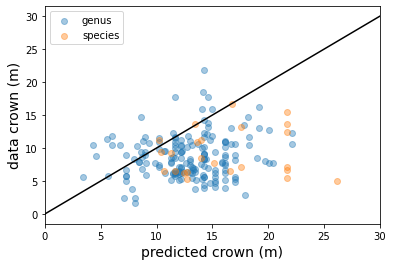

In [13]:
area = 'Sarphati'
x_max_1, x_max_2 = 45, 30
plotfunc(results_df_sarphati, area, x_max_1, x_max_2)

# age influence


[1970, 1990]


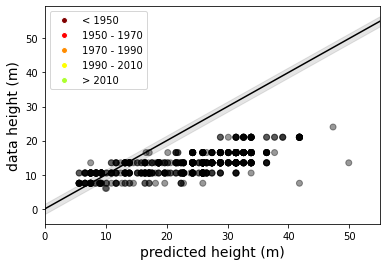

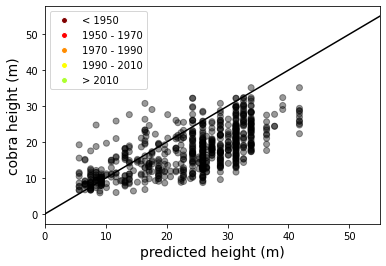

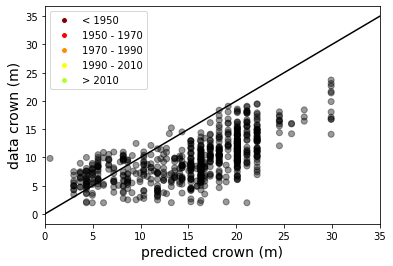

In [14]:
area = 'age_Wallengebied'
print(boundaries[1:3])
x_max_1, x_max_2 = 55, 35
plotfunc_years(results_df_wallengebied, area, x_max_1, x_max_2, colors, boundaries)

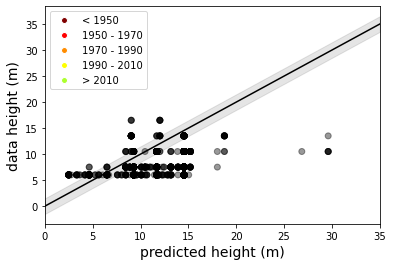

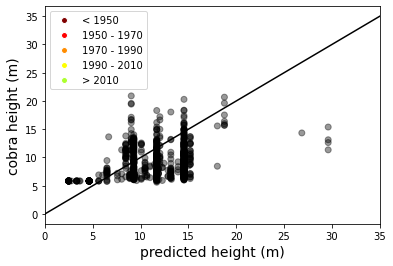

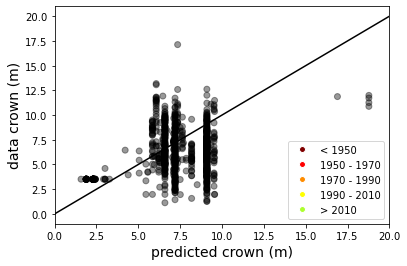

In [15]:
area = 'age_IJburg'
x_max_1, x_max_2 = 35, 20
plotfunc_years(results_df_ijburg, area, x_max_1, x_max_2, colors, boundaries)

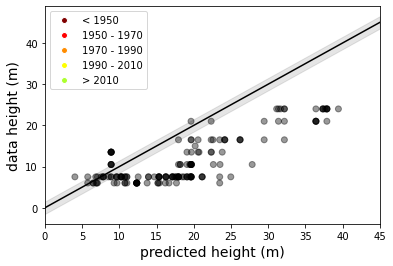

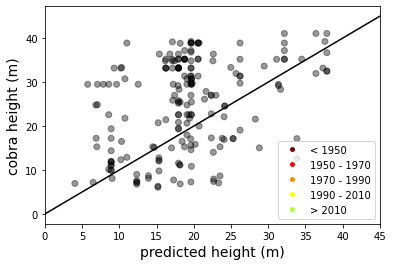

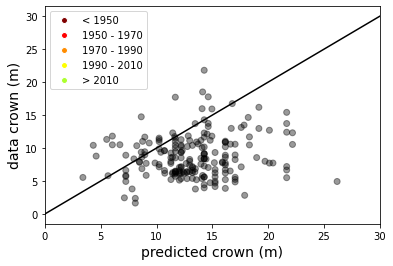

In [16]:
area = 'age_Sarphati'
x_max_1, x_max_2 = 45, 30
plotfunc_years(results_df_sarphati, area, x_max_1, x_max_2, colors, boundaries)

# Extremely stratified pattern in IJburg

In [41]:
def plotfunc_categories(results_df, area, x_max_1, x_max_2, colors, categories):
    
    legend_elements = []                
    
    for x in range(len(categories)):
        legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[x], label=categories[x]))
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='unclassified'))

    # plot gemeente height against predicted height
    plt.scatter(results_df['Predicted height'], results_df['Gemeente height'], c=results_df['Colors'], alpha=0.4)
    plt.xlabel('predicted height (m)', fontsize=14)
    plt.ylabel('data height (m)', fontsize=14)
    x=np.arange(0,x_max_1+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_1)
    plt.fill_between(x, x+1.5, x-1.5, color='black', alpha=0.1)
    plt.legend(handles=legend_elements)
    plt.savefig('plots/gemeente_height_{}'.format(area), dpi=300)
    plt.show()

    # plot cobra height against predicted 
    plt.scatter(results_df['Predicted height'], results_df['Cobra height'], c=results_df['Colors'], alpha=0.4)
    plt.xlabel('predicted height (m)', fontsize=14)
    plt.ylabel('cobra height (m)', fontsize=14)
    x=np.arange(0,x_max_1+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_1)
    plt.legend(handles=legend_elements)
    plt.savefig('plots/cobra_height_{}'.format(area), dpi=300)
    plt.show()

    # plot cobra crown against predicted crown
    plt.scatter(results_df['Predicted crown'], results_df['Cobra crown'], c=results_df['Colors'], alpha=0.4)
    plt.xlabel('predicted crown (m)', fontsize=14)
    plt.ylabel('data crown (m)', fontsize=14)
    x=np.arange(0,x_max_2+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_2)
    plt.legend(handles=legend_elements)
    plt.savefig('plots/crown_{}'.format(area), dpi=300)
    plt.show()

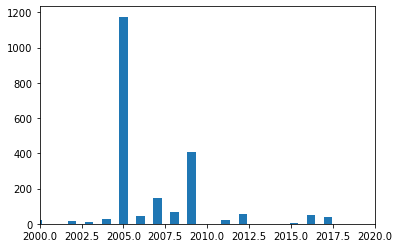

Counter({2005: 1175, 2009: 406, 2007: 147, 0: 92, 2008: 67, 2012: 54, 2016: 49, 2006: 45, 2017: 36, 2004: 29, 2011: 23, 1997: 20, 2000: 20, 2002: 14, 1996: 10, 2003: 9, 1987: 7, 1977: 5, 1967: 5, 2015: 2, 2018: 1})

Counter({'Platanus hispanica': 428, 'Ulmus `Dodoens`': 240, 'Tilia tomentosa': 233, 'Robinia pseudoacacia `Nyirségi`': 192, 'Ulmus cv.': 64, 'Salix alba': 58, 'Gleditsia triacanthos': 51, 'Ulmus `Lobel`': 48, 'Ulmus': 45, 'Ulmus `Columella`': 44, 'Ulmus hollandica `Groeneveld`': 42, 'Ulmus `Clusius`': 41, 'Ulmus `Regal`': 39, 'Populus alba': 38, 'Ulmus `Cathedral`': 37, 'Onbekend': 37, 'Ulmus `New Horizon`': 36, 'Ulmus `Homestead`': 35, 'Ulmus hollandica `Pioneer`': 34, 'Platanus orientalis cuneata': 33, 'Ulmus `Plantijn`': 31, 'Liriodendron tulipifera': 27, 'Prunus avium': 27, 'Aesculus hippocastanum `Baumannii`': 24, 'Robinia pseudoacacia': 22, 'Tilia tomentosa `Brabant`': 22, 'Malus domestica cv.': 19, 'Pterocarya fraxinifolia': 18, 'Ailanthus altissima': 16, 'Acer sacch

In [18]:
df = pd.read_csv('data/ijburg_trees.csv')
plt.hist(df['Plantjaar'][df['Plantjaar'] != 0], bins = 100)
plt.xlim(2000, 2020)
plt.show()

from collections import Counter
years=Counter(df['Plantjaar'])
species=Counter(df['Soortnaam_WTS'])
print(years)
print()
print(species)

In [19]:
colors = ['y', 'b', 'g', 'r', 'm']
categories = [2005, 2007, 2008, 2009]

for i, tree in results_df_ijburg.iterrows():
    
    # read out origin
    origin = tree['Plantjaar']
    
    if origin == categories[0]:
        results_df_ijburg.at[i, 'Colors'] = colors[0]
    if origin == categories[1]:
        results_df_ijburg.at[i, 'Colors'] = colors[1]
    if origin == categories[2]:
        results_df_ijburg.at[i, 'Colors'] = colors[2]
    if origin == categories[3]:
        results_df_ijburg.at[i, 'Colors'] = colors[3]        

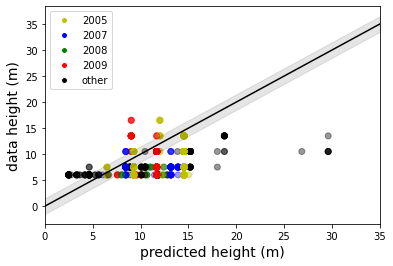

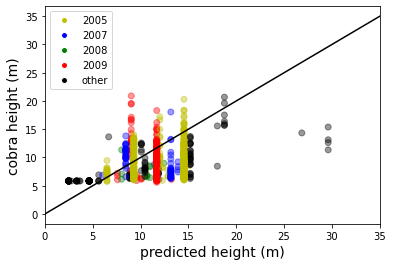

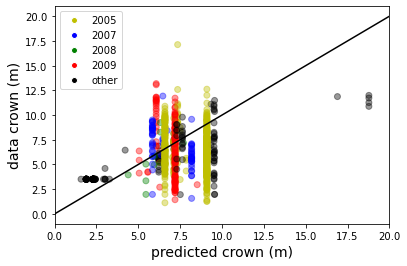

In [20]:
area = 'research_IJburg'
x_max_1, x_max_2 = 35, 20
plotfunc_categories(results_df_ijburg, area, x_max_1, x_max_2, colors, categories)

In [21]:
results_df_ijburg['Colors'] = 'black'
colors = ['y', 'b', 'g', 'r', 'm']
categories = ['Ulmus', 'Tilia', 'Populus']


for i, tree in results_df_ijburg.iterrows():
    
    # read out name and type
    name = tree['Soortnaam_WTS']
    group = name.split()
    genus = str(group[0])
    
    if genus == categories[0]:
        results_df_ijburg.at[i, 'Colors'] = colors[0]
    if genus == categories[1]:
        results_df_ijburg.at[i, 'Colors'] = colors[1]
    if genus == categories[2]:
        results_df_ijburg.at[i, 'Colors'] = colors[2]

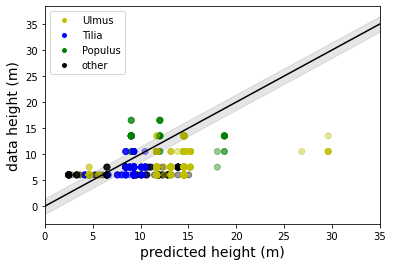

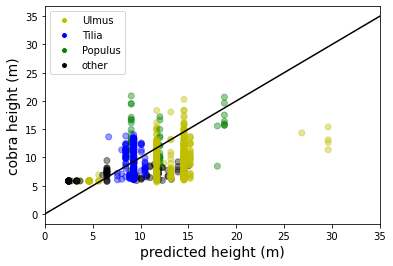

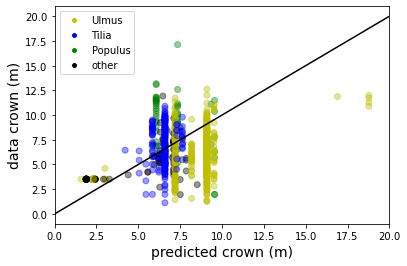

In [22]:
area = 'research_IJburg_speciesd'
x_max_1, x_max_2 = 35, 20
plotfunc_categories(results_df_ijburg, area, x_max_1, x_max_2, colors, categories)

# BGT influence

In [49]:
wallengebied_data = pd.read_csv('data/wallengebied_validation.csv')
ijburg_data = pd.read_csv('data/ijburg_validation.csv')
sarphati_data = pd.read_csv('data/sarphati_validation.csv')

In [50]:
results_df_wallengebied = wallengebied_data
results_df_wallengebied['Colors'] = 'black'
area = 'Wallengebied_bgt'
colors = ['y', 'b', 'g', 'r', 'm']
categories = ['open_ground', 'light_load', 'moderate_load', 'heavy_load']

for i, tree in results_df_wallengebied.iterrows():
    
    # read out name and type
    bgt_class = tree['BGT_class']
    
    if bgt_class == categories[0]:
        results_df_wallengebied.at[i, 'Colors'] = colors[0]
    if bgt_class == categories[1]:
        results_df_wallengebied.at[i, 'Colors'] = colors[1]
    if bgt_class == categories[2]:
        results_df_wallengebied.at[i, 'Colors'] = colors[2]
    if bgt_class == categories[3]:
        results_df_wallengebied.at[i, 'Colors'] = colors[3]

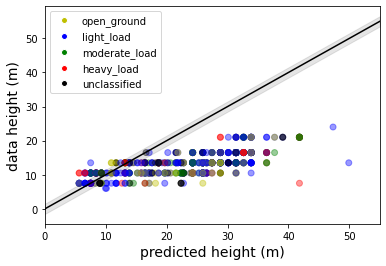

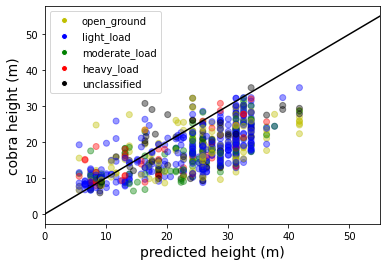

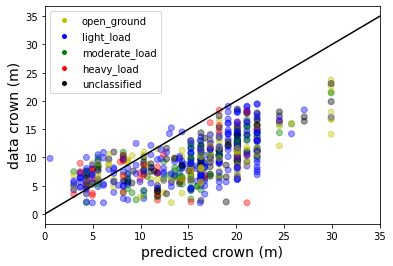

In [51]:
x_max_1, x_max_2 = 55, 35
plotfunc_categories(results_df_wallengebied, area, x_max_1, x_max_2, colors, categories)

In [52]:
results_df_ijburg = ijburg_data
results_df_ijburg['Colors'] = 'black'
area = 'IJburg_bgt'
colors = ['y', 'b', 'g', 'r', 'm']
categories = ['open_ground', 'light_load', 'moderate_load', 'heavy_load']

for i, tree in results_df_ijburg.iterrows():
    
    # read out name and type
    bgt_class = tree['BGT_class']
    
    if bgt_class == categories[0]:
        results_df_ijburg.at[i, 'Colors'] = colors[0]
    if bgt_class == categories[1]:
        results_df_ijburg.at[i, 'Colors'] = colors[1]
    if bgt_class == categories[2]:
        results_df_ijburg.at[i, 'Colors'] = colors[2]
    if bgt_class == categories[3]:
        results_df_ijburg.at[i, 'Colors'] = colors[3]


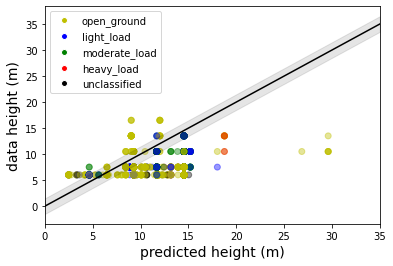

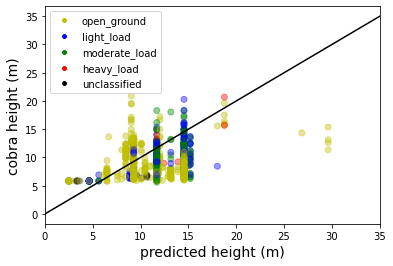

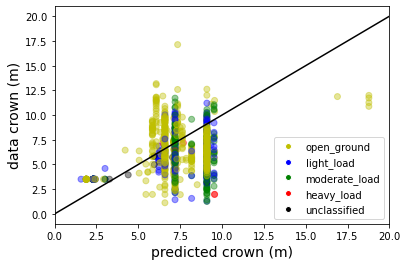

In [53]:
x_max_1, x_max_2 = 35, 20
plotfunc_categories(results_df_ijburg, area, x_max_1, x_max_2, colors, categories)

In [54]:
results_df_sarphati = sarphati_data
results_df_sarphati['Colors'] = 'black'
area = 'Sarphati_bgt'
colors = ['y', 'b', 'g', 'r', 'm']
categories = ['open_ground', 'light_load', 'moderate_load', 'heavy_load']

for i, tree in results_df_sarphati.iterrows():
    
    # read out name and type
    bgt_class = tree['BGT_class']
    
    if bgt_class == categories[0]:
        results_df_sarphati.at[i, 'Colors'] = colors[0]
    if bgt_class == categories[1]:
        results_df_sarphati.at[i, 'Colors'] = colors[1]
    if bgt_class == categories[2]:
        results_df_sarphati.at[i, 'Colors'] = colors[2]
    if bgt_class == categories[3]:
        results_df_sarphati.at[i, 'Colors'] = colors[3]

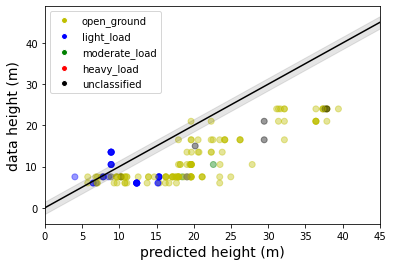

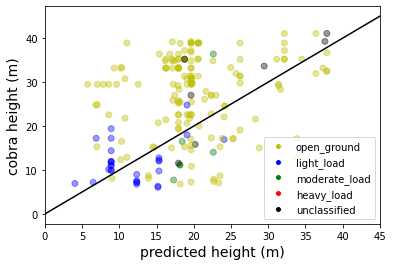

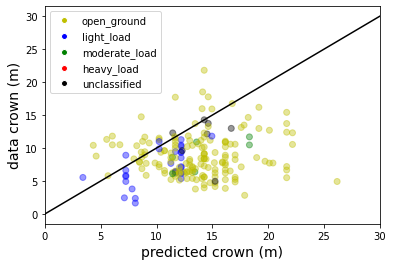

In [55]:
x_max_1, x_max_2 = 45, 30
plotfunc_categories(results_df_sarphati, area, x_max_1, x_max_2, colors, categories)

# Amsterdam Centraal

In [29]:
def validate_centraal(df, data_df, species, data_year): 
    results_df = copy.deepcopy(df)
   
    results_df['Gemeente height'] = np.nan
    
    results_df['Predicted height'] = np.nan
    results_df['Predicted crown'] = np.nan
    
    results_df['Species'] = np.nan
    results_df['BGT_class'] = None
    
    results_df['Colors'] = 'black'

    for i, tree in df.iterrows():
        type = tree['Boomtype']
        if type == 'Vormboom' or type == 'Knotboom':
            continue

        # retrieve tree id
        tree_number = tree['Boomnummer']

        # read out name and type
        name = tree['Soortnaam_WTS']

        if name in species:
            results_df.at[i, 'Species'] = 1
        else: 
            results_df.at[i, 'Species'] = 0
        
#         # read out tree position
#         lng = tree['LNG']
#         lat = tree['LAT']
#         rd_x, rd_y = wgs_to_rd(lat, lng)

#         # determine type of ground from bgt
#         col, row, i_index, j_index = WMTS_calculator(rd_x, rd_y)
#         try:
#             properties = get_properties(col, row, i_index, j_index)
#             bgt_class = bgt_classifier(properties)
#         except:
#             print('BGT retrieval function was not executed')
#             bgt_class = None
#         results_df.at[i, 'BGT_class'] = bgt_class

        # read out origin
        origin = tree['Plantjaar']
        
#         if origin < boundaries[0]:
#             results_df.at[i, 'Colors'] = colors[0]
#         if origin >= boundaries[0] and origin < boundaries[1]:
#             results_df.at[i, 'Colors'] = colors[1]
#         if origin >= boundaries[1] and origin < boundaries[2]:
#             results_df.at[i, 'Colors'] = colors[2]
#         if origin >= boundaries[2] and origin < boundaries[3]:
#             results_df.at[i, 'Colors'] = colors[3]            
#         if origin >= boundaries[3]:
#             results_df.at[i, 'Colors'] = colors[4]  
            
        # predict height and crown with model
        height_model, crown_model = predict(data_year, name, tree_number, origin, type, data_df)
        results_df.at[i, 'Predicted height'] = height_model
        results_df.at[i, 'Predicted crown'] = crown_model

        # read out height string from gemeente data and convert to average of the range
        height_string = tree['Boomhoogte']
        if height_string != 'Onbekend' and height_model != 0:
            height_range = []
            for word in height_string.split():
                if word.isdigit():
                    height_range.append(int(word))
            height_data = np.mean(height_range)
            results_df.at[i, 'Gemeente height'] = height_data

        # retrieve cobra crown and height
        index = cobra_df.index[cobra_df.uid_gemeente == tree_number]
        if len(index) != 0 and crown_model > 0:
            crown_data = df.at[index[0], 'Cobra_crown']
            height_cobra = df.at[index[0], 'Cobra_height']
            if height_cobra > 3:
                results_df.at[i, 'Cobra height'] = height_cobra
                results_df.at[i, 'Cobra crown'] = crown_data
    
    return results_df

In [30]:
def plotfunc_centraal(results_df, area, x_max_1, x_max_2):
    # plot gemeente height against predicted height
    plt.scatter(results_df['Predicted height'][results_df['Species'] == 0], results_df['Gemeente height'][results_df['Species'] == 0], c='C0', alpha=0.4, label='genus')
    plt.scatter(results_df['Predicted height'][results_df['Species'] == 1], results_df['Gemeente height'][results_df['Species'] == 1], c='C1', alpha=0.4, label='species')
    plt.xlabel('predicted height (m)', fontsize=14)
    plt.ylabel('data height (m)', fontsize=14)
    x=np.arange(0,x_max_1+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_1)
    plt.fill_between(x, x+1.5, x-1.5, color='black', alpha=0.1)
    plt.legend()
    plt.savefig('plots/gemeente_height_species_{}'.format(area), dpi=300)
    plt.show()

    # plot cobra height against predicted 
    plt.scatter(results_df['Predicted height'][results_df['Species'] == 0], results_df['Cobra_height'][results_df['Species'] == 0], c='C0', alpha=0.4, label='genus')
    plt.scatter(results_df['Predicted height'][results_df['Species'] == 1], results_df['Cobra_height'][results_df['Species'] == 1], c='C1', alpha=0.4, label='species')
    plt.xlabel('predicted height (m)', fontsize=14)
    plt.ylabel('cobra height (m)', fontsize=14)
    x=np.arange(0,x_max_1+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_1)
    plt.legend()
    plt.savefig('plots/cobra_height_species_{}'.format(area), dpi=300)
    plt.show()
    
    # plot cobra crown against predicted crown
    plt.scatter(results_df['Predicted crown'][results_df['Species'] == 0], results_df['Cobra_crown'][results_df['Species'] == 0], c='C0', alpha=0.4, label='genus')
    plt.scatter(results_df['Predicted crown'][results_df['Species'] == 1], results_df['Cobra_crown'][results_df['Species'] == 1], c='C1', alpha=0.4, label='species')
    plt.xlabel('predicted crown (m)', fontsize=14)
    plt.ylabel('data crown (m)', fontsize=14)
    x=np.arange(0,x_max_2+1,1)
    plt.plot(x, x, c='black')
    plt.xlim(0, x_max_2)
    plt.legend()
    plt.savefig('plots/crown_species_{}'.format(area), dpi=300)
    plt.show()


In [31]:
# load in data for Amsterdam centraal
df = pd.read_excel('data/centraal_trees.xlsx')
df.LNG = df.LNG / 100000
df.LAT = df.LAT / 1000000
results_df_centraal = validate_centraal(df, data_df, species, data_year)
display(results_df_centraal.head())


,OBJECTNUMMER,Soortnaam_NL,Boomnummer,Soortnaam_WTS,Boomtype,Boomhoogte,Plantjaar,Eigenaar,Beheerder,Categorie,...,Cobra_crown,Cobra_height,RD_X,RD_Y,Gemeente height,Predicted height,Predicted crown,Species,BGT_class,Colors
0,235853,Hollandse iep (cultuurvariëteit),339708,Ulmus hollandica `Commelin`,Boom niet vrij uitgroeiend,12 tot 15 m.,1960,Gemeente Amsterdam,Stadsdeel Centrum,Ulmus,...,14.303625,18.695071,121616,488227,13.5,31.385340,20.111460,0.0,None,black
1,235852,Huntingdon-iep,339709,Ulmus hollandica `Vegeta`,Boom niet vrij uitgroeiend,12 tot 15 m.,1960,Gemeente Amsterdam,Stadsdeel Centrum,Ulmus,...,10.749255,18.482607,121613,488215,13.5,31.385340,20.111460,0.0,None,black
2,236051,Iep (cultuurvariëteit),339700,Ulmus `Dodoens`,Boom niet vrij uitgroeiend,9 tot 12 m.,1980,Gemeente Amsterdam,Stadsdeel Centrum,Ulmus,...,9.075389,12.150799,121558,488127,10.5,25.934385,16.308812,1.0,None,black
3,236050,Huntingdon-iep,339701,Ulmus hollandica `Vegeta`,Boom niet vrij uitgroeiend,12 tot 15 m.,1970,Gemeente Amsterdam,Stadsdeel Centrum,Ulmus,...,9.223249,16.300188,121558,488117,13.5,28.819722,18.215915,0.0,None,black
4,236258,Hollandse iep (cultuurvariëteit),339684,Ulmus hollandica `Belgica`,Gekandelaberde boom,12 tot 15 m.,1940,Gemeente Amsterdam,Stadsdeel Centrum,Ulmus,...,14.389600,22.718201,121599,488078,13.5,36.412176,24.510854,0.0,None,black


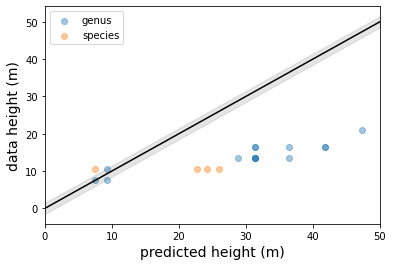

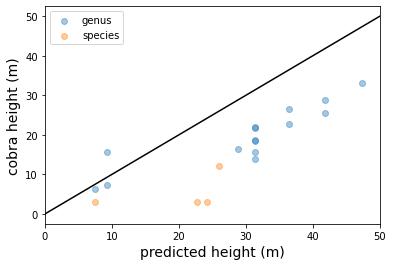

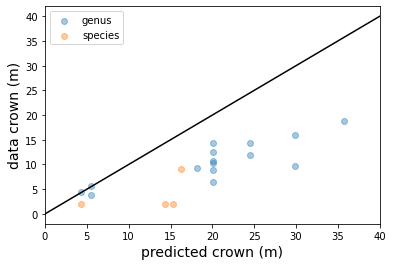

In [32]:
area = 'Centraal'
x_max_1, x_max_2 = 50, 40
plotfunc_centraal(results_df_centraal, area, x_max_1, x_max_2)

In [33]:
# results_df_wallengebied.to_csv('data/wallengebied_validation.csv')
# results_df_ijburg.to_csv('data/ijburg_validation.csv')
# results_df_sarphati.to_csv('data/sarphati_validation.csv')
